In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('UniversalBank_unprocessed.csv')
data.head()

,ID,Age,Experience,Income,Family,CCAvg,Education,Mortgage,CD Account,Online,CreditCard,Personal Loan
0,1,39,13.0,58.0,3,2.10,Undergraduate,169,0,1,0,0
1,2,51,25.0,18.0,1,0.30,Advanced,93,0,0,1,0
2,3,43,13.0,38.0,3,2.00,Advanced,0,0,1,0,0
3,4,37,12.0,60.0,4,2.10,Advanced,217,0,1,0,0
4,5,23,NaN,149.0,1,6.33,Undergraduate,305,0,0,1,0


In [4]:
data.shape

(1117, 12)

In [5]:
data.dtypes

ID                 int64
Age                int64
Experience       float64
Income           float64
Family             int64
CCAvg            float64
Education         object
Mortgage           int64
CD Account         int64
Online             int64
CreditCard         int64
Personal Loan      int64
dtype: object

In [6]:
data.isnull().sum()

ID               0
Age              0
Experience       4
Income           3
Family           0
CCAvg            0
Education        0
Mortgage         0
CD Account       0
Online           0
CreditCard       0
Personal Loan    0
dtype: int64

In [7]:
data = data.dropna()

In [8]:
# Handling negative values
# Replace negative values in 'Experience' with 0
data['Experience'] = data['Experience'].apply(lambda x: 0 if x < 0 else x)

# Check if there are any negative values left in the 'Experience' column
remaining_negative_values = data[data['Experience'] < 0].shape[0]
remaining_negative_values


0

### Exploratory Data Analysis

#### 1. How many customers are present ?

In [9]:
# Count of distinct IDs
distinct_id_count = data['ID'].nunique()
distinct_id_count

1110

#### 2. What is the range of age do the customers belong to?

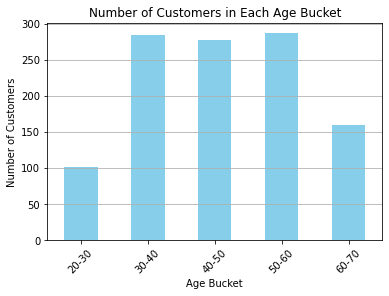

In [10]:
import matplotlib.pyplot as plt

# Create age buckets
bins = [20, 30, 40, 50, 60, 70]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70']

# Count the number of customers in each bucket
age_bucket_counts = pd.cut(data['Age'], bins=bins, labels=labels, right=False).value_counts().sort_index()

# Visualization
age_bucket_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Customers in Each Age Bucket')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


- Most customers fall within the 30-60 age ranges.

#### 3. What is Income bucket range of customers?

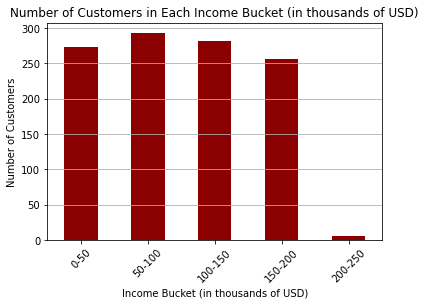

In [11]:
# Create income buckets
income_bins = [0, 50, 100, 150, 200, 250]
income_labels = ['0-50', '50-100', '100-150', '150-200', '200-250']


# Count the number of customers in each income bucket
income_bucket_counts = pd.cut(data['Income'], bins=income_bins, labels=income_labels, right=False).value_counts().sort_index()


# Plot
income_bucket_counts.plot(kind='bar', color='darkred')
plt.title('Number of Customers in Each Income Bucket (in thousands of USD)')
plt.xlabel('Income Bucket (in thousands of USD)')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

- A significant number of customers fall within the 50-100k USD income range.

#### 4. What is the monthly average credit card spend of the customers?

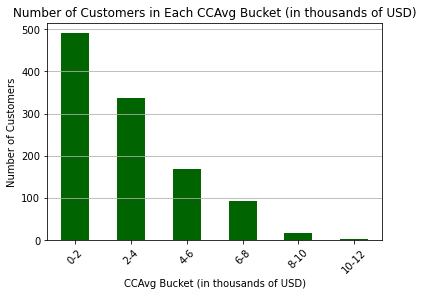

In [12]:
# Create CCAvg buckets
ccavg_bins = [0, 2, 4, 6, 8, 10, 12]
ccavg_labels = ['0-2', '2-4', '4-6', '6-8', '8-10', '10-12']

# Count the number of customers in each CCAvg bucket
ccavg_bucket_counts = pd.cut(data['CCAvg'], bins=ccavg_bins, labels=ccavg_labels, right=False).value_counts().sort_index()

# Plot
ccavg_bucket_counts.plot(kind='bar', color='darkgreen')
plt.title('Number of Customers in Each CCAvg Bucket (in thousands of USD)')
plt.xlabel('CCAvg Bucket (in thousands of USD)')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


- A substantial number of customers have an average monthly credit card spending in the range of 0-4k USD.

#### 5. What is the value of mortgage held with the Bank ?

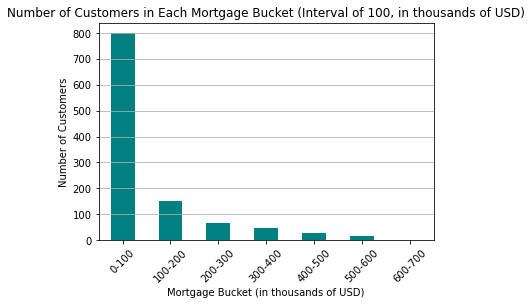

In [13]:
# Create Mortgage buckets with an interval of 100
mortgage_bins = list(range(0, 701, 100))
mortgage_labels = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-600', '600-700']

# Count the number of customers in each Mortgage bucket with interval of 100
mortgage_bucket = pd.cut(data['Mortgage'], bins=mortgage_bins, labels=mortgage_labels, right=False).value_counts().sort_index()

# Plot
mortgage_bucket.plot(kind='bar', color='teal')
plt.title('Number of Customers in Each Mortgage Bucket (Interval of 100, in thousands of USD)')
plt.xlabel('Mortgage Bucket (in thousands of USD)')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

- A significant number of customers have a mortgage value in the 0-100k USD range.

#### 6. What is the family size of customers?

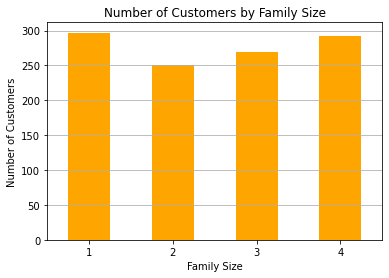

In [14]:
# Count the number of customers based on family size
family_size_counts = data['Family'].value_counts().sort_index()

# Plot
family_size_counts.plot(kind='bar', color='orange')
plt.title('Number of Customers by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()


#### 7. Which category in the Education column occurs most frequently?

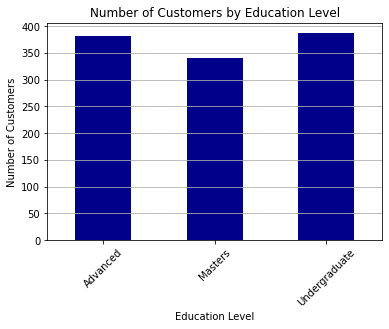

In [15]:
# Count the number of customers based on education level
education_counts = data['Education'].value_counts().sort_index()

# Plot
education_counts.plot(kind='bar', color='darkblue')
plt.title('Number of Customers by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


- A large number of customers have an "Undergraduate" level of education.
- The counts for "Advanced" and "Doctorate" levels are relatively similar, with the "Advanced" level slightly surpassing the "Doctorate" level.

#### 8. How many customers have CD account ?

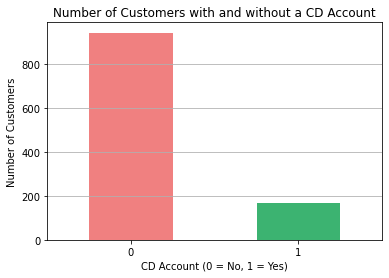

In [16]:
# Count the number of customers with and without a CD account
cd_account_counts = data['CD Account'].value_counts()

# Plotting the number of customers with and without a CD account
cd_account_counts.plot(kind='bar', color=['lightcoral', 'mediumseagreen'])
plt.title('Number of Customers with and without a CD Account')
plt.xlabel('CD Account (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


- 85% customers do not have a Certificate of Deposit (CD) account.
- 15% customers have a CD account.

 #### 9. How many customers use internet banking facilities?

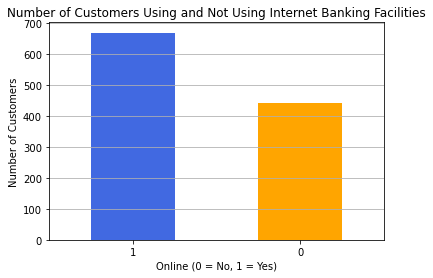

In [17]:
# Count the number of customers using and not using internet banking facilities
online_counts = data['Online'].value_counts()

# Plotting the number of customers using and not using internet banking facilities
online_counts.plot(kind='bar', color=['royalblue', 'orange'])
plt.title('Number of Customers Using and Not Using Internet Banking Facilities')
plt.xlabel('Online (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

- 60% customers use internet banking facilities.
- 30% customers do not use internet banking facilities.

#### 10. How many customers use a credit card issued by the Bank?

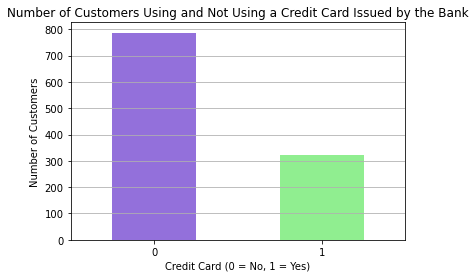

In [18]:
# Count the number of customers using and not using a credit card issued by the bank
credit_card_counts = data['CreditCard'].value_counts()

# Plotting the number of customers using and not using a credit card issued by the bank
credit_card_counts.plot(kind='bar', color=['mediumpurple', 'lightgreen'])
plt.title('Number of Customers Using and Not Using a Credit Card Issued by the Bank')
plt.xlabel('Credit Card (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

- 71% customers do not use a credit card issued by the bank.
- 29% customers use a credit card issued by the bank.

#### 11. How many customers accepted the personal loan offered in the last campaign?

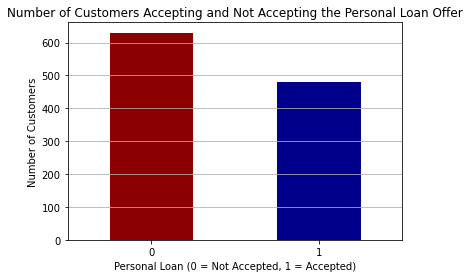

In [19]:
# Count the number of customers who accepted and did not accept the personal loan offered in the last campaign
personal_loan_counts = data['Personal Loan'].value_counts()

# Plotting the number of customers in relation to the personal loan offer
personal_loan_counts.plot(kind='bar', color=['darkred', 'darkblue'])
plt.title('Number of Customers Accepting and Not Accepting the Personal Loan Offer')
plt.xlabel('Personal Loan (0 = Not Accepted, 1 = Accepted)')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

- 57% customers did not accept the personal loan offer.
- 43% customers accepted the personal loan offer.

#### 12. Identifying the attributes that are highly correlated to 'Personal Loan'

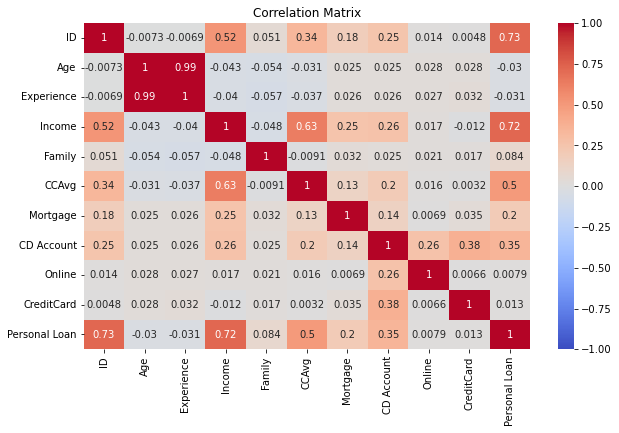

In [20]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

- Variables like Age and Experience show a high positive correlation, which is expected since, generally, as age increases, professional experience also increases.

### Data Processing

#### 1. Identifying relationships between the predictor variables, to find any potential multicollinearity problem

Focusing on the predictors helps in getting a clear understanding of the relationships among them, which can be useful when considering feature selection.

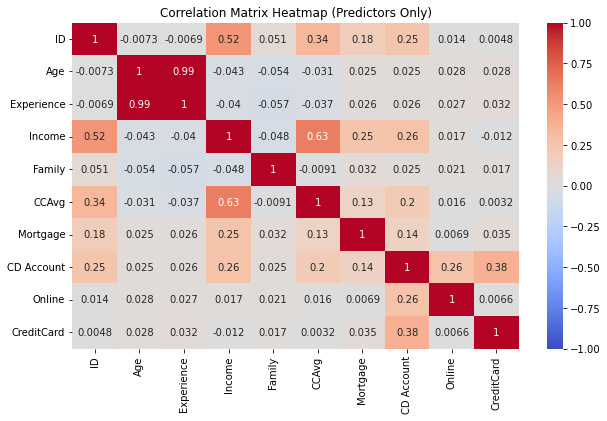

In [21]:
# Drop the target variable 'Personal Loan' from the correlation matrix
predictors_correlation = corr_matrix.drop('Personal Loan', axis=0).drop('Personal Loan', axis=1)

#Visualization
plt.figure(figsize=(10, 6))
sns.heatmap(predictors_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap (Predictors Only)")
plt.show()

From the correlation matrix among predictors, we observe that 'Age' and 'Eduaction' have high correlations (greater than 0.9), which suggest that they convey similar information.

#### 2. Dropping 'Experience' column

In [22]:
# Drop the 'Experience' column
data = data.drop('Experience', axis=1)
data.head()

,ID,Age,Income,Family,CCAvg,Education,Mortgage,CD Account,Online,CreditCard,Personal Loan
0,1,39,58.0,3,2.1,Undergraduate,169,0,1,0,0
1,2,51,18.0,1,0.3,Advanced,93,0,0,1,0
2,3,43,38.0,3,2.0,Advanced,0,0,1,0,0
3,4,37,60.0,4,2.1,Advanced,217,0,1,0,0
5,6,60,30.0,4,1.3,Undergraduate,118,0,1,1,0


#### 3. Dealing with Categorical variables

In [23]:
# One-hot encode the 'Education' column
data_encoded = pd.get_dummies(data, columns=['Education'], drop_first=True)

# Display the first few rows of the encoded data
data_encoded.head()

,ID,Age,Income,Family,CCAvg,Mortgage,CD Account,Online,CreditCard,Personal Loan,Education_Masters,Education_Undergraduate
0,1,39,58.0,3,2.1,169,0,1,0,0,0,1
1,2,51,18.0,1,0.3,93,0,0,1,0,0,0
2,3,43,38.0,3,2.0,0,0,1,0,0,0,0
3,4,37,60.0,4,2.1,217,0,1,0,0,0,0
5,6,60,30.0,4,1.3,118,0,1,1,0,0,1


#### 4. Splitting the Data into Train and Test

In [24]:
from sklearn.model_selection import train_test_split

# Define predictors and target variable
X = data_encoded.drop(['ID', 'Personal Loan'], axis=1)
y = data_encoded['Personal Loan']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((777, 10), (333, 10), (777,), (333,))

#### 5. Normalizing the data

In [25]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = scaler.transform(X_test)

# Display the first few rows of the scaled training data
X_train_scaled[:5, :]

array([[ 0.37662494, -1.03021693, -1.29132265, -0.61784985,  0.52232859,
        -0.41679253,  0.82132148, -0.64243854, -0.65445307, -0.73805935],
       [ 0.81222717,  0.33380115,  1.31932184,  1.40068193, -0.56639974,
        -0.41679253,  0.82132148, -0.64243854,  1.52799344, -0.73805935],
       [ 0.63798628,  1.35226798, -1.29132265,  0.10305435, -0.56639974,
        -0.41679253,  0.82132148, -0.64243854,  1.52799344, -0.73805935],
       [ 0.81222717, -0.37548825,  1.31932184,  1.06425996, -0.56639974,
        -0.41679253, -1.21755005, -0.64243854, -0.65445307,  1.35490458],
       [-1.45290443,  0.42473569,  0.44910701,  1.40068193,  2.83488293,
        -0.41679253,  0.82132148, -0.64243854, -0.65445307, -0.73805935]])

### Building the k-NN classifier

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the k-NN classifier with k=5 (default)
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier to the scaled training data
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

#### 1. Predicting the result

In [27]:
# Predict on the scaled testing data
y_pred_knn = knn.predict(X_test_scaled)
y_pred_knn

# Calculate accuracy
test_accuracy_knn = f1_score(y_test, y_pred_knn)

In [28]:
# Predict on the scaled training data
y_train_pred_knn = knn.predict(X_train_scaled)

# Calculate accuracy for training data
train_accuracy_knn = f1_score(y_train, y_train_pred_knn)

#### 2. Calculating the Performance Metrics 

In [29]:
train_accuracy_knn, test_accuracy_knn  # Displaying training and test accuracy side by side for comparison

(0.9310872894333844, 0.8989547038327526)

- Model is found to be overfit as the accuracy is better in training set than test set. However, the percentage difference is 1.62%, which is not Highly significant

#### 3. Evaluation

Checking to use a larger value of k for the k-NN classifier to see if the gap narrows to avoid potential overfitting

In [30]:
# Initialize lists to store accuracies
train_accuracies = []
test_accuracies = []

# Define a range of k values
k_values = range(1, 20)  # testing k from 1 to 50

# Loop over k values to train the k-NN classifier and store the accuracies
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    # Predict and compute accuracy for training set
    y_train_pred = knn.predict(X_train_scaled)
    train_accuracy = f1_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Predict and compute accuracy for test set
    y_test_pred = knn.predict(X_test_scaled)
    test_accuracy = f1_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Display the accuracies for different values of k
results = pd.DataFrame({
    'k': k_values,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies
})

results

,k,Train Accuracy,Test Accuracy
0,1,1.000000,0.885813
1,2,0.934189,0.867647
2,3,0.940639,0.913495
3,4,0.928685,0.887273
4,5,0.931087,0.898955
5,6,0.932707,0.885714
6,7,0.937213,0.888889
7,8,0.922835,0.884058
8,9,0.930663,0.900000
9,10,0.916797,0.887273


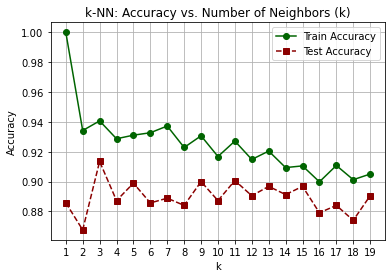

In [31]:
import matplotlib.pyplot as plt

# Visualizing the training and testing accuracies for different values of k
plt.plot(k_values, train_accuracies, marker='o', label='Train Accuracy', color='darkgreen')
plt.plot(k_values, test_accuracies, marker='s', linestyle='--', label='Test Accuracy', color='darkred')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k-NN: Accuracy vs. Number of Neighbors (k)')
plt.legend()
plt.grid(True)
plt.xticks(k_values)
plt.show()

- for k = 19, the percentage difference between train and test set accuracy score is lesser at 1.61%. Thus, k = 19 provides a good balance between performance on the training data and generalization to the test data.

### Building Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

# Train the Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [33]:
# Predict on the test set
y_pred_log = log_reg.predict(X_test_scaled)
y_pred_log

# Calculate accuracy for Logistic Regression classifier
test_accuracy_log = f1_score(y_test, y_pred_log)

In [34]:
# Predict on the train set
y_train_pred_log = log_reg.predict(X_train_scaled)

# Calculate accuracy for Logistic Regression classifier
train_accuracy_log = f1_score(y_train, y_train_pred_log)

In [35]:
train_accuracy_log, test_accuracy_log  # Displaying training and test accuracy side by side for comparison

(0.8851963746223565, 0.8737201365187713)

- Model is found to be overfit as the accuracy is better in training set than test set. However, the percentage difference is 1.30%, which is small

### Evaluating the Models

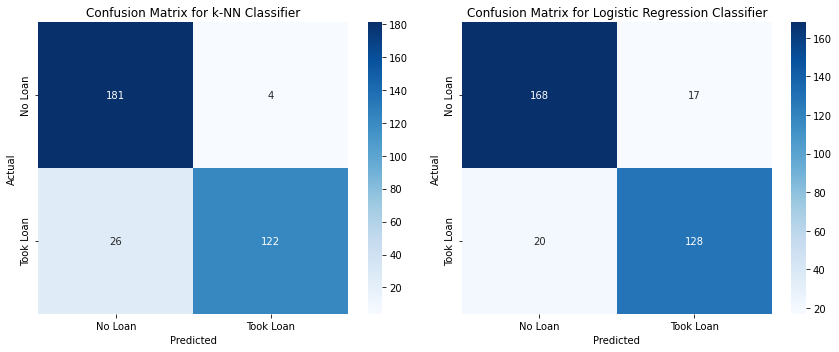

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix for k-NN predictions on the test set
cm_knn = confusion_matrix(y_test, y_test_pred)

# Compute the confusion matrix for Logistic Regression predictions on the test set
cm_logistic = confusion_matrix(y_test, y_pred_log)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix for k-NN Classifier
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=['No Loan', 'Took Loan'], yticklabels=['No Loan', 'Took Loan'], ax=axes[0])
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')
axes[0].set_title('Confusion Matrix for k-NN Classifier')

# Plot the confusion matrix for Logistic Regression Classifier
sns.heatmap(cm_logistic, annot=True, fmt="d", cmap="Blues", xticklabels=['No Loan', 'Took Loan'], yticklabels=['No Loan', 'Took Loan'], ax=axes[1])
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')
axes[1].set_title('Confusion Matrix for Logistic Regression Classifier')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

#### k-NN Classifier:

- The best value of k was determined to be 19 based on the F1 scores for the training and testing data.
- The model showed a slight overfit, with a percentage difference of 1.61% between the training and test set F1 scores.

#### Logistic Regression Classifier:

- The model also demonstrated a slight overfit, with a percentage difference of 1.30% between the training and test set F1 scores.
- Its confusion matrix provides similar insights as the k-NN model.

Logistic regression model is recommended for deployment or further testing, primarily due to its balance of performance, interpretability, and scalability. 